In [1]:
!pip install pandas pyarrow yfinance fortitudo_tech matplotlib numpy seaborn

  Using cached pandas-2.3.3-cp312-cp312-manylinux_2_24_x86_64.manylinux_2_28_x86_64.whl.metadata (91 kB)
  Using cached pyarrow-22.0.0-cp312-cp312-manylinux_2_28_x86_64.whl.metadata (3.2 kB)
  Using cached yfinance-0.2.66-py2.py3-none-any.whl.metadata (6.0 kB)
  Using cached fortitudo_tech-1.1.12-py3-none-any.whl.metadata (5.8 kB)
  Using cached matplotlib-3.10.7-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (11 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached multitasking-0.0.12-py3-none-any.whl
  Using cached frozendict-2.4.7-py3-none-any.whl.metadata (23 kB)
  Using cached peewee-3.18.3-py3-none-any.whl
  Using cached curl_cffi-0.13.0-cp39-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (13 kB)
  Using cached websockets-15.0.1-cp312-cp312-manylinux_2_5_x86_64.manylinux1_x86_64.manyli

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import fortitudo.tech as ft
import seaborn as sns
from cvxopt import matrix, solvers
from copy import copy
from scipy import stats

In [3]:
data = pd.read_parquet("merged_portfolio_data.parquet")
data['date'] = pd.to_datetime(data['date'])
data = data.set_index('date')
selected_assets = ['NVDA', 'ISRG','APO', 'DECK', 'COST', 'CAT', 'BTU', 'SHW', 'NRG', 'NFLX', 'CBRE', 'GC=F'
]
existing_assets = [c for c in selected_assets if c in data.columns]
data = data[existing_assets]
print(f"Assets found in file: {len(existing_assets)} / {len(selected_assets)}")
data = data[data > 0]
data_clean = data.dropna(axis=0, how='any')

pnl = np.log(data_clean / data_clean.shift(1)).dropna()

print(f"Returns: {pnl.shape[0]} days × {pnl.shape[1]} assets")
print(f"Date range: {pnl.index[0].date()} → {pnl.index[-1].date()}")

Assets found in file: 12 / 12
Returns: 2470 days × 12 assets
Date range: 2016-01-05 → 2025-11-11


In [4]:
instrument_names = pnl.columns.tolist()
means = pnl.mean().values
covariance_matrix = pnl.cov().values

vols = np.sqrt(np.diag(covariance_matrix))
correlation_matrix = np.diag(vols**-1) @ covariance_matrix @ np.diag(vols**-1)

In [5]:
I = len(instrument_names)
G = -np.eye(I)
h = np.zeros(I)
mv_opt = ft.MeanVariance(means, covariance_matrix, G, h)

In [6]:
B = 1000  # Number of efficient frontiers
P = 9  # Number of portfolios used to span the efficient frontiers
N = 100  # Sample size for parameter estimation
np.random.seed(3)  # To avoid numerical instability
return_sim = np.random.multivariate_normal(means, covariance_matrix, (N, B))

In [7]:
# Base frontier with no parameter uncertainty
frontier = mv_opt.efficient_frontier(P)
results = np.full((P, 2), np.nan)
results[:, 0] = means @ frontier
for p in range(P):
    results[p, 1] = frontier[:, p] @ covariance_matrix @ frontier[:, p]

## Analysis of Parameter Uncertainty

Mean, Variance, and Correlation importance.

In [8]:
# Mean Uncertainty
solvers.options['show_progress'] = False  

frontier_mean = np.full((I, P, B), np.nan)
mean_results = np.full((P, 2, B), np.nan)

failed = 0
for b in range(B):
    try:
        means_run = np.mean(return_sim[:, b, :], axis=0)
        mv_opt._expected_return_row = -matrix(means_run).T
        frontier_mean[:, :, b] = mv_opt.efficient_frontier(P)
        mean_results[:, 0, b] = means @ frontier_mean[:, :, b]
        for p in range(P):
            mean_results[p, 1, b] = frontier_mean[:, p, b] @ covariance_matrix @ frontier_mean[:, p, b]
    except:
        failed += 1
        continue

mv_opt._expected_return_row = -matrix(means).T  # Reset means

print(f"Mean uncertainty frontiers computed: {B - failed}/{B} succeeded")
if failed > 0:
    print(f"  ({failed} bootstraps failed due to numerical issues)")

Mean uncertainty frontiers computed: 991/1000 succeeded
  (9 bootstraps failed due to numerical issues)


In [9]:
# Volatility Uncertainty
frontier_vol = np.full((I, P, B), np.nan)
vol_results = np.full((P, 2, B), np.nan)

failed = 0
for b in range(B):
    try:
        vols_run = np.diag(np.std(return_sim[:, b, :], axis=0))
        cov_matrix_run = vols_run @ correlation_matrix @ vols_run
        mv_opt._P = matrix(1000 * cov_matrix_run)
        frontier_vol[:, :, b] = mv_opt.efficient_frontier(P)
        vol_results[:, 0, b] = means @ frontier_vol[:, :, b]
        for p in range(P):
            vol_results[p, 1, b] = frontier_vol[:, p, b] @ covariance_matrix @ frontier_vol[:, p, b]
    except:
        failed += 1
        continue

mv_opt._P = matrix(1000 * covariance_matrix)  # Reset covariance

print(f"Vol uncertainty frontiers computed: {B - failed}/{B} succeeded")
if failed > 0:
    print(f"  ({failed} bootstraps failed due to numerical issues)")

Vol uncertainty frontiers computed: 1000/1000 succeeded


In [10]:
# Correlation Uncertainty
frontier_cor = np.full((I, P, B), np.nan)
cor_results = np.full((P, 2, B), np.nan)

failed = 0
for b in range(B):
    try:
        cor_matrix_run = ft.correlation_matrix(return_sim[:, b, :]).values
        cov_matrix_run = np.diag(vols) @ cor_matrix_run @ np.diag(vols)
        mv_opt._P = matrix(1000 * cov_matrix_run)
        frontier_cor[:, :, b] = mv_opt.efficient_frontier(P)
        cor_results[:, 0, b] = means @ frontier_cor[:, :, b]
        for p in range(P):
            cor_results[p, 1, b] = frontier_cor[:, p, b] @ covariance_matrix @ frontier_cor[:, p, b]
    except:
        failed += 1
        continue

mv_opt._P = matrix(1000 * covariance_matrix)  

print(f"Correlation uncertainty frontiers computed: {B - failed}/{B} succeeded")
if failed > 0:
    print(f"  ({failed} bootstraps failed due to numerical issues)")

Correlation uncertainty frontiers computed: 1000/1000 succeeded


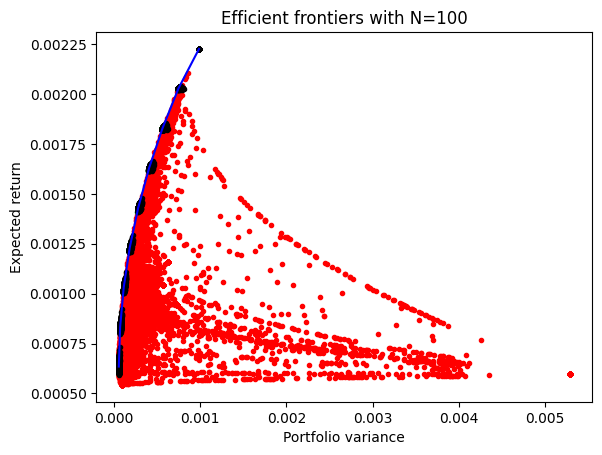

In [11]:
plt.plot(mean_results[:, 1, :], mean_results[:, 0, :], 'r.')
plt.plot(vol_results[:, 1, :], vol_results[:, 0, :], 'g.')
plt.plot(cor_results[:, 1, :], cor_results[:, 0, :], 'k.')
plt.plot(results[:, 1], results[:, 0], 'b-')
plt.title(f'Efficient frontiers with N={N}')
plt.ylabel('Expected return')
plt.xlabel('Portfolio variance')
plt.show()

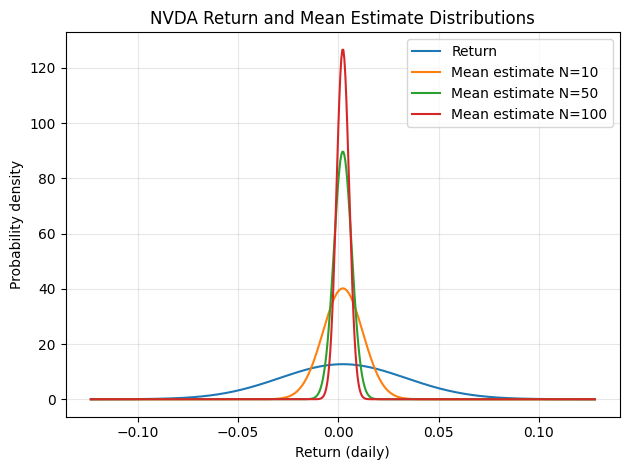

In [12]:
asset_idx = 0  
asset_name = instrument_names[asset_idx]

x_min = means[asset_idx] - 4 * vols[asset_idx]
x_max = means[asset_idx] + 4 * vols[asset_idx]
x = np.linspace(x_min, x_max, 500)

plt.plot(x, stats.norm.pdf(x, means[asset_idx], vols[asset_idx]))
plt.plot(x, stats.norm.pdf(x, means[asset_idx], vols[asset_idx] / np.sqrt(10)))
plt.plot(x, stats.norm.pdf(x, means[asset_idx], vols[asset_idx] / np.sqrt(50)))
plt.plot(x, stats.norm.pdf(x, means[asset_idx], vols[asset_idx] / np.sqrt(100)))
plt.legend(['Return', 'Mean estimate N=10', 'Mean estimate N=50', 'Mean estimate N=100'])
plt.title(f'{asset_name} Return and Mean Estimate Distributions')
plt.ylabel('Probability density')
plt.xlabel('Return (daily)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Resampling
Vorobets: Sample convergence. He uses the traditional resampling approach on the middle portfolio to investigate how many samples are needed before the resulting exposures start to converge.

In [13]:
pf_index = 4

In [14]:
# Efficient frontier without resampling
np.round(frontier[:, pf_index] * 100, 1)

array([45.9,  0. ,  0. ,  0. ,  3.9,  6.9,  0. ,  0. , 12.6,  0. ,  0. ,
       30.8])

In [15]:
track_idx = [0, 4, 5, 8, 11]  # highest allocation assets
track_names = [instrument_names[i] for i in track_idx]

exposure_re_vals = np.full((len(track_idx), B), np.nan)

for b in range(B):
    re_pf = np.nanmean(frontier_mean[:, pf_index, 0:b+1], axis=1)
    exposure_re_vals[:, b] = re_pf[track_idx]

In [ ]:
asset_index

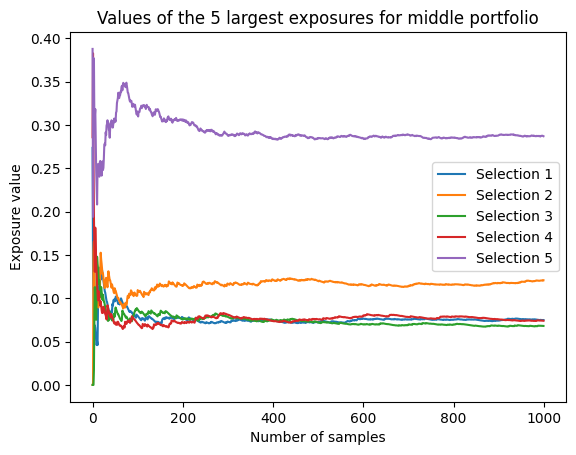

In [16]:
x = exposure_re_vals.shape[0]   # number of selected exposures

plt.plot(exposure_re_vals.T)
labels = [f"Selection {i+1}" for i in range(x)]
plt.legend(labels)
plt.xlabel('Number of samples')
plt.ylabel('Exposure value')
plt.title(f'Values of the {x} largest exposures for middle portfolio')
plt.show()


## Exposure Stacking

In [17]:
solvers.options['show_progress'] = False

def exposure_stacking(L, frontier, num_samples):
    """Computes the L-fold Exposure Stacking.
    
    Partitions the first num_samples samples from the frontier into L sets 
    of equal size and computes the L-fold Exposure Stacking.
    
    Args:
        L: Number of partition sets.
        frontier: Resampled exposures frontier with shape (I, P, B).
        num_samples: Number of samples to include.
    
    Returns:
        Exposure Stacking portfolio.    
    """
    partition_size = num_samples // L
    M = frontier[:, pf_index, :num_samples].T
    P = np.zeros((num_samples, num_samples))
    q = np.zeros((num_samples, 1))
    
    for l in range(L):
        K_l = np.arange(l * partition_size, (l + 1) * partition_size)
        M_l = copy(M)
        M_l[K_l, :] = 0
        P = P + M_l @ M_l.T
        sum_exposures_K_l = np.sum(frontier[:, pf_index, K_l], axis=1)
        q = q + (M_l @ sum_exposures_K_l)[:, np.newaxis]
    
    P = matrix(2 * partition_size * P)
    q = matrix(-2 * q)
    
    # Weights must sum to one
    A = matrix(np.ones((1, num_samples)))
    b = matrix(np.array([[1.]]))
    
    # Weights must be nonnegative
    G = matrix(-np.identity(num_samples))
    h = matrix(np.zeros((num_samples, 1)))
    
    sol = solvers.qp(P, q, G, h, A, b)
    w = sol['x']
    exposure = np.squeeze(M.T @ w)
    
    return exposure

In [18]:
valid_mask = ~np.isnan(frontier_mean[0, pf_index, :])
num_valid = valid_mask.sum()
frontier_clean = frontier_mean[:, :, valid_mask]

print(f"Valid bootstraps: {num_valid}/{B}")

num_samples = num_valid
exposure_2 = exposure_stacking(2, frontier_clean, num_samples)
exposure_5 = exposure_stacking(5, frontier_clean, num_samples)
exposure_B = exposure_stacking(num_valid, frontier_clean, num_samples)

print(f"\nExposure Stacking Results (Portfolio {pf_index}):\n")
print(f"{'Asset':<8} {'L=2':>8} {'L=5':>8} {'L=B':>8}")
print("-" * 35)
for i, name in enumerate(instrument_names):
    print(f"{name:<8} {exposure_2[i]*100:>7.1f}% {exposure_5[i]*100:>7.1f}% {exposure_B[i]*100:>7.1f}%")

Valid bootstraps: 991/1000

Exposure Stacking Results (Portfolio 4):

Asset         L=2      L=5      L=B
-----------------------------------
NVDA         6.7%     7.4%     7.5%
ISRG         1.1%     4.0%     4.7%
APO          1.6%     4.3%     4.9%
DECK         1.7%     4.6%     5.4%
COST        15.9%    13.2%    12.1%
CAT          5.4%     6.6%     6.8%
BTU          5.2%     5.9%     7.0%
SHW          2.7%     4.9%     5.5%
NRG          6.6%     7.3%     7.4%
NFLX         4.0%     4.7%     6.0%
CBRE         0.0%     3.1%     4.0%
GC=F        49.2%    34.0%    28.7%


In [19]:
# Out-of-sample simulations
return_sim_oos = np.random.multivariate_normal(means, covariance_matrix, (N, B))

In [20]:
def risk_return(pf):
    """Computes the out of sample risk and return of the portfolio.

    Args:
        pf: Portfolio to measure risk and return against.

    Returns:
        Array of shape (2, B) with risk and return for each of the B simulations.
    """
    risk_return = np.full((2, B), np.nan)
    for b in range(B):
        means_run = np.mean(return_sim_oos[:, b, :], axis=0)
        cov_run = np.cov(return_sim_oos[:, b, :], rowvar=False)
        risk_return[0, b] = pf @ cov_run @ pf
        risk_return[1, b] = means_run @ pf
    return risk_return

In [21]:
re_rr = risk_return(re_pf)
re_rar = re_rr[1, :] / re_rr[0, :]
frontier_rr = risk_return(frontier[:, pf_index])
frontier_rar = frontier_rr[1, :] / frontier_rr[0, :]
es_2_rr = risk_return(exposure_2)
es_2_rar = es_2_rr[1, :] / es_2_rr[0, :]
es_5_rr = risk_return(exposure_5)
es_5_rar = es_5_rr[1, :] / es_5_rr[0, :]
es_B_rr = risk_return(exposure_B)
es_B_rar = es_B_rr[1, :] / es_B_rr[0, :]

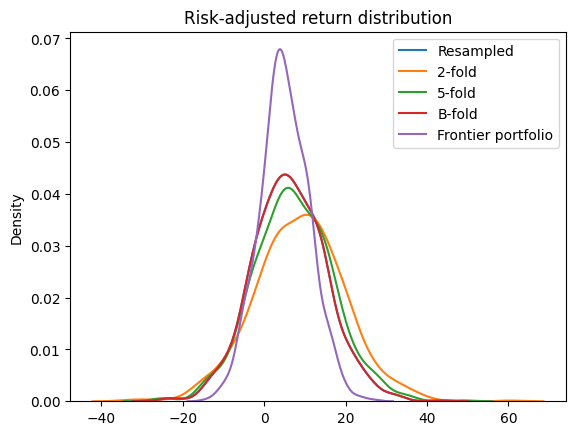

In [22]:
sns.kdeplot(x=re_rar)
sns.kdeplot(x=es_2_rar)
sns.kdeplot(x=es_5_rar)
sns.kdeplot(x=es_B_rar)
sns.kdeplot(x=frontier_rar)
plt.title('Risk-adjusted return distribution')
plt.legend(['Resampled', '2-fold', '5-fold', 'B-fold', 'Frontier portfolio'])
plt.show()

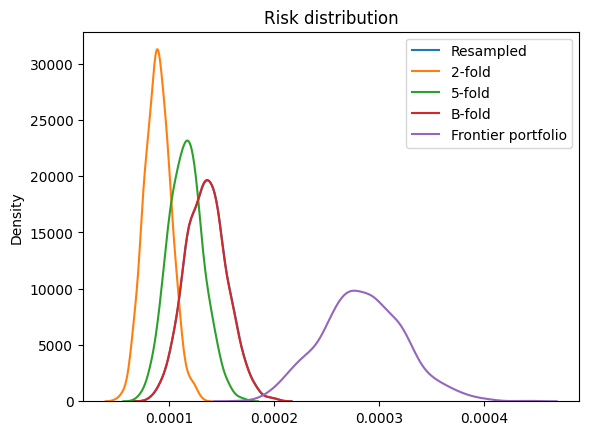

In [23]:
sns.kdeplot(x=re_rr[0, :], label='Resampled')
sns.kdeplot(x=es_2_rr[0, :], label='2-fold')
sns.kdeplot(x=es_5_rr[0, :], label='5-fold')
sns.kdeplot(x=es_B_rr[0, :], label='B-fold')
sns.kdeplot(x=frontier_rr[0, :], label='Frontier portfolio')

plt.title('Risk distribution')
plt.legend()
plt.show()


In [24]:
for name, x in [
    ("Resampled", re_rr[0,:]),
    ("2-fold", es_2_rr[0,:]),
    ("5-fold", es_5_rr[0,:]),
    ("B-fold", es_B_rr[0,:]),
    ("Frontier", frontier_rr[0,:])
]:
    print(name, np.mean(x), np.std(x))


Resampled 0.00013529162486938047 1.9520412828859625e-05
2-fold 8.88804966379142e-05 1.2799374080043658e-05
5-fold 0.0001157071734111513 1.6648946298711985e-05
B-fold 0.00013508325943010837 1.9489663704007673e-05
Frontier 0.0002842293977706459 3.948284118115256e-05


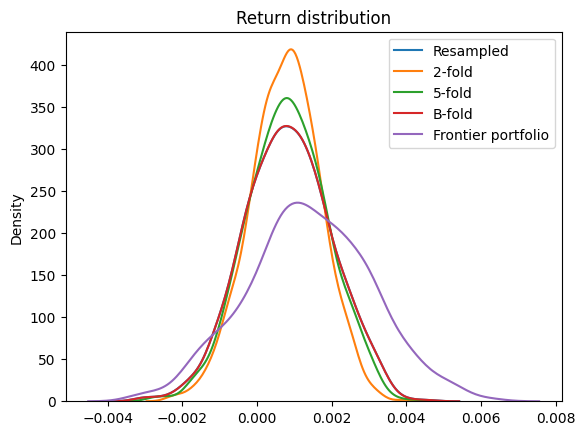

In [25]:
sns.kdeplot(x=re_rr[1, :])
sns.kdeplot(x=es_2_rr[1, :])
sns.kdeplot(x=es_5_rr[1, :])
sns.kdeplot(x=es_B_rr[1, :])
sns.kdeplot(x=frontier_rr[1, :])
plt.title('Return distribution')
plt.legend(['Resampled', '2-fold', '5-fold', 'B-fold', 'Frontier portfolio'])
plt.show()


In [26]:
summary_stats = pd.DataFrame({
    'Method': ['Base Frontier', 'Resampled', 'ES L=2', 'ES L=5', 'ES L=B'],
    'Mean Return': [
        np.nanmean(frontier_rr[1, :]) * 100,
        np.nanmean(re_rr[1, :]) * 100,
        np.nanmean(es_2_rr[1, :]) * 100,
        np.nanmean(es_5_rr[1, :]) * 100,
        np.nanmean(es_B_rr[1, :]) * 100
    ],
    'Mean Risk': [
        np.nanmean(frontier_rr[0, :]) * 100,
        np.nanmean(re_rr[0, :]) * 100,
        np.nanmean(es_2_rr[0, :]) * 100,
        np.nanmean(es_5_rr[0, :]) * 100,
        np.nanmean(es_B_rr[0, :]) * 100
    ],
    'Annlzd Mean Return': [
        np.nanmean(frontier_rr[1, :]) * 100 * 252,
        np.nanmean(re_rr[1, :]) * 100 * 252,
        np.nanmean(es_2_rr[1, :]) * 100 * 252,
        np.nanmean(es_5_rr[1, :]) * 100 * 252,
        np.nanmean(es_B_rr[1, :]) * 100 * 252
    ],
    'Annlzd Mean Risk': [
        np.nanmean(frontier_rr[0, :]) * 10000 * np.sqrt(252),
        np.nanmean(re_rr[0, :]) * 10000 * np.sqrt(252),
        np.nanmean(es_2_rr[0, :]) * 10000 * np.sqrt(252),
        np.nanmean(es_5_rr[0, :]) * 10000 * np.sqrt(252),
        np.nanmean(es_B_rr[0, :]) * 10000 * np.sqrt(252)
    ],
    'Sharpe': [
        (np.nanmean(frontier_rr[1, :]) * 100 * 252) / (np.nanmean(frontier_rr[0, :]) * 10000 * np.sqrt(252)),
        (np.nanmean(re_rr[1, :]) * 100 * 252) / (np.nanmean(re_rr[0, :]) * 10000 * np.sqrt(252)),
        (np.nanmean(es_2_rr[1, :]) * 100 * 252) / (np.nanmean(es_2_rr[0, :]) * 10000 * np.sqrt(252)),
        (np.nanmean(es_5_rr[1, :]) * 100 * 252) / (np.nanmean(es_5_rr[0, :]) * 10000 * np.sqrt(252)),
        (np.nanmean(es_B_rr[1, :]) * 100 * 252) / (np.nanmean(es_B_rr[0, :]) * 10000 * np.sqrt(252))
    ]
})

summary_stats = summary_stats.set_index('Method')
print("Out-of-Sample Performance Summary:\n")
print(summary_stats.round(4))

Out-of-Sample Performance Summary:

               Mean Return  Mean Risk  Annlzd Mean Return  Annlzd Mean Risk  \
Method                                                                        
Base Frontier       0.1396     0.0284             35.1763           45.1200   
Resampled           0.0821     0.0135             20.6937           21.4769   
ES L=2              0.0759     0.0089             19.1326           14.1093   
ES L=5              0.0810     0.0116             20.4009           18.3679   
ES L=B              0.0821     0.0135             20.6956           21.4438   

               Sharpe  
Method                 
Base Frontier  0.7796  
Resampled      0.9635  
ES L=2         1.3560  
ES L=5         1.1107  
ES L=B         0.9651  
